In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import os

from sklearn.model_selection import train_test_split
from torchsummary import summary
import torch.nn.functional as F

import shutil
from torch import Tensor
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from joblib import Parallel, delayed

min_number_of_samples = 360

In [4]:
class EEG_DataSet(Dataset):
    def __init__(self, eegs_dir, transform=None, target_transform=None):
        self.eegs_dir = eegs_dir
        self.eeg_examples = Parallel(n_jobs=-1)(delayed(EEG_DataSet.extract_sample)(os.path.join(eegs_dir, path)) for path in os.listdir(eegs_dir))
        self.transform = transform
        self.target_transform = target_transform

    @classmethod    
    def extract_sample(cls, sample_path):
        eeg_df = pd.read_csv(sample_path, index_col=0, header=None).T
        eeg_npArray = np.array(eeg_df, dtype=np.float32)[:min_number_of_samples]
        return eeg_npArray

    def __len__(self):
        return len(self.eeg_examples)

    def __getitem__(self, idx):
        eeg_npArray  = self.eeg_examples[idx].T
        eeg_npArray = eeg_npArray[:, :, np.newaxis]
        eeg_tensor = torch.tensor(eeg_npArray, dtype=torch.float32)
        
        if self.transform: eeg_tensor = self.transform(eeg_tensor)
        if self.target_transform: eeg_tensor = self.target_transform(eeg_tensor)
        return eeg_npArray, eeg_tensor

train_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\train",)
test_dataset = EEG_DataSet("..\Training Data\BrainVis_Preprocessing\eegs\\test",)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [24]:
path = "..\Training Data\BrainVis_Preprocessing\eegs\\test"

def split(batch, num_splits):
    return np.array(np.split(batch, num_splits, axis=2))

def rejoin(batch_splits, original_shape):
    return batch_splits.reshape(original_shape)

def create_mask(splits, p):
    return np.random.choice([True, False], (splits.shape), [p, p-1])

def apply_mask(splits, mask):
    return np.where(mask, splits, 0)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, num_channels, latent_dim):
        super(Autoencoder, self).__init__()
        encode_ratio = 32
        flattened_size = 5760
        self.encode_conv1 = nn.Conv2d(num_channels, encode_ratio, kernel_size=3, stride=2, padding=1)
        self.encode_conv2 = nn.Conv2d(encode_ratio, encode_ratio*2, kernel_size=3, stride=2, padding=1)
        self.encode_conv3 = nn.Conv2d(encode_ratio*2, encode_ratio*4, kernel_size=3, stride=2, padding=1)
        self.encode_linear = nn.Linear(flattened_size, latent_dim)
        
        self.decode_linear = nn.Linear(latent_dim, flattened_size)
        self.decode_conv1 = nn.ConvTranspose2d(encode_ratio*4, encode_ratio*2, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.decode_conv2 = nn.ConvTranspose2d(encode_ratio*2, encode_ratio, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
        self.decode_conv3 = nn.ConvTranspose2d(encode_ratio, num_channels, kernel_size=3, stride=2, padding=1, output_padding=(1, 0))
    def forward(self, x):
        # Encode
        x = F.relu(self.encode_conv1(x))
        x = F.relu(self.encode_conv2(x))
        x = F.relu(self.encode_conv3(x))
        self.shape_before_encode_flattening = x.shape[1:]
        x = x.view(x.size(0), -1)
        x = self.encode_linear(x)

        # Decode
        x = self.decode_linear(x)
        x = x.view(x.size(0), *self.shape_before_encode_flattening)
        x = F.relu(self.decode_conv1(x))
        x = F.relu(self.decode_conv2(x))
        x = F.relu(self.decode_conv3(x))
        return x

def train(num_splits, split_prob, learning_rate, num_epochs):
    model = Autoencoder(num_channels=5, latent_dim=500)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    num_epochs = num_epochs
    losses = []
    for epoch in range(num_epochs):
        batch_loss = []
        for data in train_loader:

            # Extract x, y pair and load y variable to GPU
            eeg_input, eeg_real = data
            eeg_real = eeg_real.to(device)

            # Split and mask the input batch
            original_shape = eeg_input.shape
            splits = split(eeg_input, num_splits)
            mask = create_mask(splits, split_prob)
            masked = apply_mask(splits, mask)
            rejoined = rejoin(masked, original_shape)

            # load masked x variable to GPU
            eeg_tensor = torch.tensor(rejoined, dtype=torch.float32)
            eeg_input = eeg_tensor.to(device)

            # Model training
            optimizer.zero_grad()
            output = model(eeg_input)
            loss = criterion(output, eeg_real)
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
        losses.append(np.mean(batch_loss))

        if epoch % 5== 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))
    
    test_loss = []
    for data in test_loader:
        eeg, _ = data
        eeg = eeg.to(device)
        output = model(eeg)
        loss = criterion(output, eeg)

        test_loss.append(loss.item())

    print(f"Average testing loss: {round(np.mean(test_loss), 4)}")
    # Save the model
    torch.save(model.state_dict(), 'conv_autoencoder.pth')

    return model, losses, test_loss

In [42]:
epoches_tested = {}
for epoch in [25, 50, 75, 100]:
    model, training_loss, test_loss = train(num_splits=5, split_prob=0.001, learning_rate=0.001, num_epochs=epoch)
    epoches_tested[f"{epoch} Epochs"] = np.mean(test_loss)


cuda
Epoch [1/25], Loss: 38990.8320
Epoch [6/25], Loss: 9262.6406
Epoch [11/25], Loss: 11372.1211
Epoch [16/25], Loss: 7708.8892
Epoch [21/25], Loss: 12726.4707
Average testing loss: 146973.1456
Test Loss: 146973.1455965909 - Epoch 25
cuda
Epoch [1/50], Loss: 37341.6914
Epoch [6/50], Loss: 47316.3164
Epoch [11/50], Loss: 12529.6104
Epoch [16/50], Loss: 14410.7529
Epoch [21/50], Loss: 8807.6963
Epoch [26/50], Loss: 6594.5503
Epoch [31/50], Loss: 24939.8496
Epoch [36/50], Loss: 14972.7441
Epoch [41/50], Loss: 28759.3516
Epoch [46/50], Loss: 29348.7031
Average testing loss: 88813.6303
Test Loss: 88813.63032670454 - Epoch 50
cuda
Epoch [1/75], Loss: 27404.4082
Epoch [6/75], Loss: 10934.2939
Epoch [11/75], Loss: 24663.0469
Epoch [16/75], Loss: 7602.4282
Epoch [21/75], Loss: 7130.2822
Epoch [26/75], Loss: 17745.8262
Epoch [31/75], Loss: 18571.2480
Epoch [36/75], Loss: 5736.3906
Epoch [41/75], Loss: 6908.7158
Epoch [46/75], Loss: 8249.8965
Epoch [51/75], Loss: 4759.6157
Epoch [56/75], Loss: 1

In [45]:
lr_tested = {}
for lr in [0.001, 0.01, 0.05, 0.1]:
    model, training_loss, test_loss = train(num_splits=5, split_prob=0.001, learning_rate=lr, num_epochs=75)
    lr_tested[f"{lr} learning rate"] = np.mean(test_loss)
print(lr_tested)

cuda
Epoch [1/75], Loss: 1847879.5000
Epoch [6/75], Loss: 1835491.3750
Epoch [11/75], Loss: 1829136.7500
Epoch [16/75], Loss: 1857170.2500
Epoch [21/75], Loss: 1821509.6250
Epoch [26/75], Loss: 1839869.8750
Epoch [31/75], Loss: 1825314.2500
Epoch [36/75], Loss: 1832621.3750
Epoch [41/75], Loss: 1826428.6250
Epoch [46/75], Loss: 1838773.0000
Epoch [51/75], Loss: 1818683.5000
Epoch [56/75], Loss: 1830697.3750
Epoch [61/75], Loss: 1831812.7500
Epoch [66/75], Loss: 1837015.3750
Epoch [71/75], Loss: 1833370.2500
Average testing loss: 1832494.8125
cuda
Epoch [1/75], Loss: 5580463.0000
Epoch [6/75], Loss: 3698056.7500
Epoch [11/75], Loss: 3671315.7500
Epoch [16/75], Loss: 3709572.5000
Epoch [21/75], Loss: 3672546.2500
Epoch [26/75], Loss: 3650297.0000
Epoch [31/75], Loss: 3633675.5000
Epoch [36/75], Loss: 3638456.2500
Epoch [41/75], Loss: 3675738.5000
Epoch [46/75], Loss: 3679099.2500
Epoch [51/75], Loss: 3637749.7500
Epoch [56/75], Loss: 3628125.0000
Epoch [61/75], Loss: 3643541.7500
Epoch [

In [48]:
split_prob = {}
for p in [0.001, 0.01, 0.05, 0.1]:
    model, training_loss, test_loss = train(num_splits=5, split_prob=p, learning_rate=0.001, num_epochs=75)
    split_prob[f"{p} split prob"] = np.mean(test_loss)
print(split_prob)

cuda
Epoch [1/75], Loss: 1854916.7500
Epoch [6/75], Loss: 1853234.2500
Epoch [11/75], Loss: 1844139.0000
Epoch [16/75], Loss: 1868922.8750
Epoch [21/75], Loss: 1842286.6250
Epoch [26/75], Loss: 1849121.2500
Epoch [31/75], Loss: 1843339.7500
Epoch [36/75], Loss: 1845362.6250
Epoch [41/75], Loss: 1859514.1250
Epoch [46/75], Loss: 1857634.5000
Epoch [51/75], Loss: 1852566.5000
Epoch [56/75], Loss: 1841735.2500
Epoch [61/75], Loss: 1851555.8750
Epoch [66/75], Loss: 1840912.7500
Epoch [71/75], Loss: 1842911.5000
Average testing loss: 1940704.5682
cuda
Epoch [1/75], Loss: 30255.4219
Epoch [6/75], Loss: 5696.8765
Epoch [11/75], Loss: 8381.2178
Epoch [16/75], Loss: 31358.6836
Epoch [21/75], Loss: 30099.5664
Epoch [26/75], Loss: 47486.8945
Epoch [31/75], Loss: 8502.4287
Epoch [36/75], Loss: 26003.0391
Epoch [41/75], Loss: 4558.1191
Epoch [46/75], Loss: 4528.6094
Epoch [51/75], Loss: 9258.2197
Epoch [56/75], Loss: 9105.8164
Epoch [61/75], Loss: 6670.0850
Epoch [66/75], Loss: 16593.0098
Epoch [71

In [51]:
split_nums = {}
for nums in [5, 8, 10, 15]:
    model, training_loss, test_loss = train(num_splits=10, split_prob=0.1, learning_rate=0.001, num_epochs=75)
    split_nums[f"{nums} split num"] = np.mean(test_loss)
print(split_nums)

cuda
Epoch [1/75], Loss: 26260.1289
Epoch [6/75], Loss: 11341.1865
Epoch [11/75], Loss: 9452.3467
Epoch [16/75], Loss: 7996.0586
Epoch [21/75], Loss: 12510.3809
Epoch [26/75], Loss: 12526.8105
Epoch [31/75], Loss: 24968.4766
Epoch [36/75], Loss: 7116.5303
Epoch [41/75], Loss: 4962.9189
Epoch [46/75], Loss: 16896.2598
Epoch [51/75], Loss: 4930.2646
Epoch [56/75], Loss: 5279.1138
Epoch [61/75], Loss: 5519.3389
Epoch [66/75], Loss: 13826.8262
Epoch [71/75], Loss: 7743.1313
Average testing loss: 251122.7159
cuda
Epoch [1/75], Loss: 66120.6641
Epoch [6/75], Loss: 7553.5269
Epoch [11/75], Loss: 9667.0615
Epoch [16/75], Loss: 8050.5420
Epoch [21/75], Loss: 16013.4922
Epoch [26/75], Loss: 7321.3989
Epoch [31/75], Loss: 9634.9053
Epoch [36/75], Loss: 32411.4727
Epoch [41/75], Loss: 17750.3223
Epoch [46/75], Loss: 4917.8604
Epoch [51/75], Loss: 10038.7334
Epoch [56/75], Loss: 5364.5820
Epoch [61/75], Loss: 15639.9932
Epoch [66/75], Loss: 12717.8770
Epoch [71/75], Loss: 9563.0791
Average testing 

In [53]:
model, training_loss, test_loss = train(num_splits=10, split_prob=0.1, learning_rate=0.001, num_epochs=75)
print(f"Test loss: {np.mean(test_loss)}")

cuda
Epoch [1/75], Loss: 19959.5312
Epoch [6/75], Loss: 4939.0430
Epoch [11/75], Loss: 8465.2891
Epoch [16/75], Loss: 12262.0664
Epoch [21/75], Loss: 6059.6167
Epoch [26/75], Loss: 5011.2012
Epoch [31/75], Loss: 6701.6172
Epoch [36/75], Loss: 14063.5869
Epoch [41/75], Loss: 15649.9248
Epoch [46/75], Loss: 5865.8237
Epoch [51/75], Loss: 3704.7068
Epoch [56/75], Loss: 6577.3989
Epoch [61/75], Loss: 6648.2266
Epoch [66/75], Loss: 8624.0156
Epoch [71/75], Loss: 31655.0898
Average testing loss: 31861.5748
Test loss: 31861.574751420456


(0.0, 100000.0)

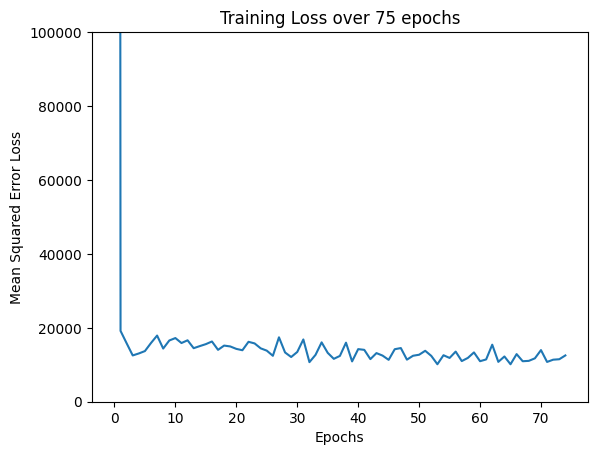

In [54]:
plt.plot(training_loss)
plt.ylabel("Mean Squared Error Loss")
plt.xlabel("Epochs")
plt.title(f"Training Loss over {75} epochs")
plt.ylim(0,100000)

Text(0.5, 1.0, 'Sample EEG')

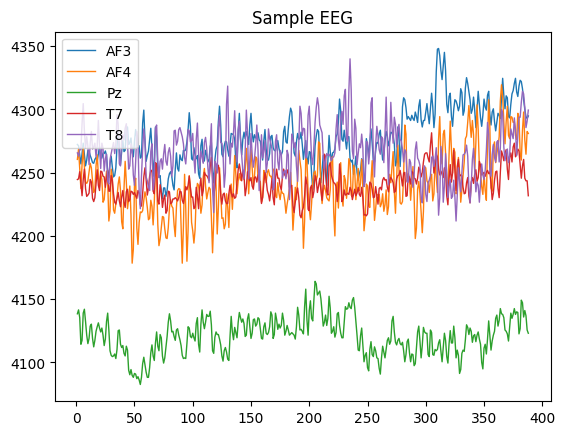

In [55]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

df = pd.read_csv(paths[0], index_col=0, header=None).T

for channel in ["AF3", "AF4", "Pz", "T7", "T8"]:
    plt.plot(df[channel], label=channel, linewidth=1)
plt.legend()
plt.title("Sample EEG")

In [56]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T

# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
pyTorch_tensor = Tensor(npArray).unsqueeze(0).to(device)
print(pyTorch_tensor.shape)
model.eval()
output = model(pyTorch_tensor).squeeze(0)
output.shape

summary(model, (5, 360, 1))

torch.Size([1, 5, 360, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 180, 1]           1,472
            Conv2d-2            [-1, 64, 90, 1]          18,496
            Conv2d-3           [-1, 128, 45, 1]          73,856
            Linear-4                  [-1, 500]       2,880,500
            Linear-5                 [-1, 5760]       2,885,760
   ConvTranspose2d-6            [-1, 64, 90, 1]          73,792
   ConvTranspose2d-7           [-1, 32, 180, 1]          18,464
   ConvTranspose2d-8            [-1, 5, 360, 1]           1,445
Total params: 5,953,785
Trainable params: 5,953,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.28
Params size (MB): 22.71
Estimated Total Size (MB): 23.00
----------------------------------------------------------------


In [57]:
data_path = "..\Training Data\MindBigData\MindBigData-Imagenet-IN\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]
min_samples = 384

def extract_means(path):
    df = pd.read_csv(path, index_col=0, header=None).T
    return df.mean(axis=0)

samples = pd.DataFrame(Parallel(n_jobs=-1)(delayed(extract_means)(path) for path in paths))
average_channel_signals = samples.mean(axis=0)
average_channel_signals.shape

(5,)

(5, 360, 1)


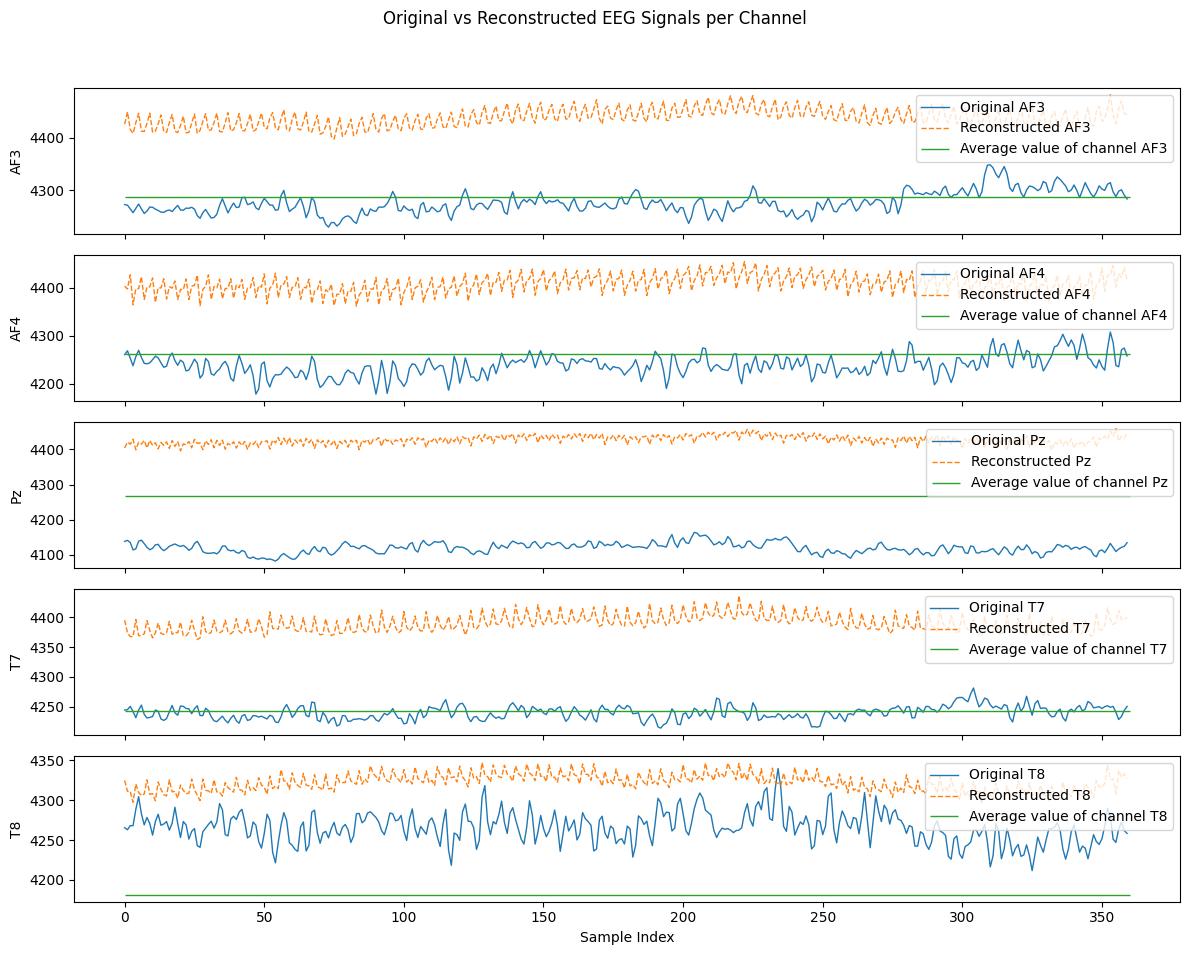

In [58]:
data_path = "..\\Training Data\\MindBigData\\MindBigData-Imagenet-IN\\MindBigData-Imagenet"
paths = [os.path.join(data_path, file) for file in os.listdir(data_path)]

# Read the first CSV file and transpose it
df = pd.read_csv(paths[0], index_col=0, header=None).T


# Define your channel names
channels = ["AF3", "AF4", "Pz", "T7", "T8"]

# Ensure the DataFrame has the correct columns
df = df[channels]

# Limit the number of samples if necessary
df = df.iloc[:min_number_of_samples]

# Process the data as per your existing code
npArray = np.array(df, dtype=np.float32).reshape(len(channels), min_number_of_samples, 1)
pyTorch_tensor = Tensor(npArray).unsqueeze(0).to(device)
output = model(pyTorch_tensor).squeeze(0)

# Get the model's output and reshape appropriately
output_np = output.cpu().detach().numpy()
print(output_np.shape)
# Plot each channel with original and reconstructed signal
fig, axes = plt.subplots(len(channels), 1, figsize=(12, 10), sharex=True)
for idx, channel in enumerate(channels):
    # Plot original signal
    axes[idx].plot(df[channel].values, label=f'Original {channel}', linewidth=1)
    # Plot reconstructed signal
    axes[idx].plot(output_np[idx], label=f'Reconstructed {channel}', linewidth=1, linestyle='--')
    axes[idx].hlines(average_channel_signals[idx], 0, min_number_of_samples, label=f"Average value of channel {channel}", linewidth=1, colors="C2")
    axes[idx].set_ylabel(channel)
    axes[idx].legend(loc='upper right')
axes[-1].set_xlabel('Sample Index')
plt.suptitle('Original vs Reconstructed EEG Signals per Channel')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()